# 데이터 불러오기

In [6]:
import yfinance as yf
TSLA = yf.download("TSLA", start="2019-01-01", end="2023-03-31")
TSLA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500


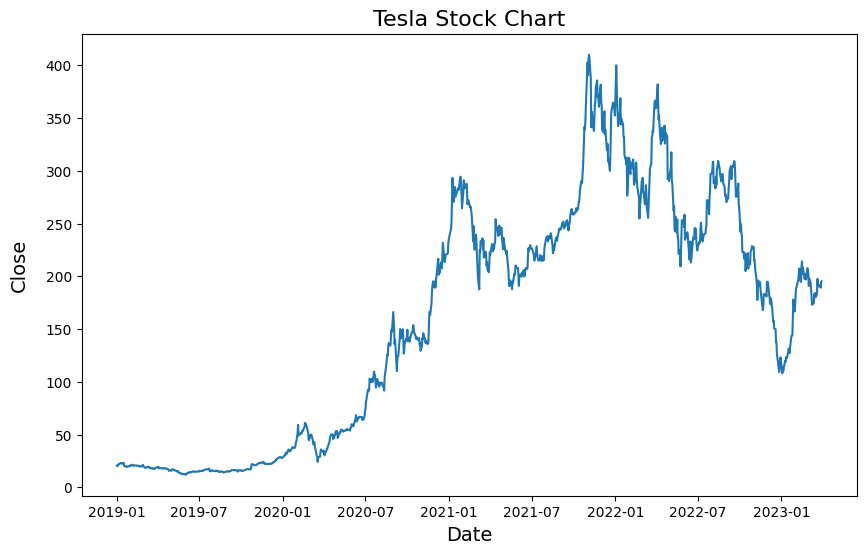

In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()
formatter.set_scientific(False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=TSLA, x=TSLA.index, y=TSLA.Close, ax=ax)
ax.set_title('Tesla Stock Chart', size = 16)
ax.set_xlabel('Date', size = 14)
ax.set_ylabel('Close', size = 14, labelpad=12)
ax.yaxis.set_major_formatter(formatter)

plt.savefig('output/scikit-learn01.png', dpi=200)
plt.show()

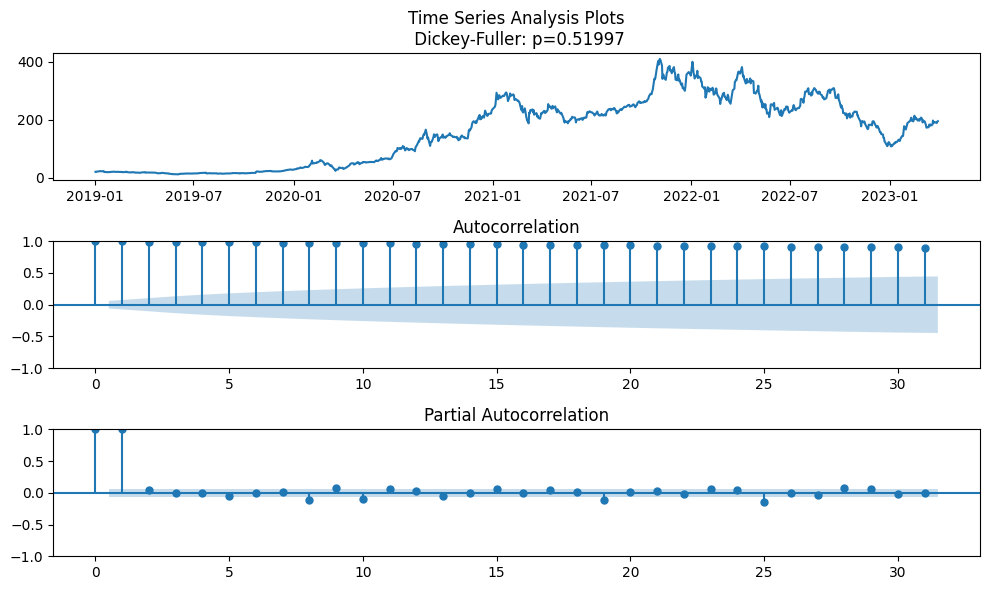

In [32]:
import pandas as pd 
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings("ignore")

def tsplot(y, lags=None, figsize=(10, 6)):
    """시계열 그래프, ACF, PACF, Dickey–Fuller test 계산한다. 
    Parameters:
        y : timeseries
        lags : how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    p_value = sm.tsa.stattools.adfuller(y)[1]
    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=figsize)
    ax[0].plot(y)
    ax[0].set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    
    smt.graphics.plot_acf(y, lags=lags, ax=ax[1])
    ax[1].set_title('Autocorrelation')
    smt.graphics.plot_pacf(y, lags=lags, ax=ax[2])
    ax[2].set_title('Partial Autocorrelation')
    plt.tight_layout()
    
tsplot(TSLA.Close)

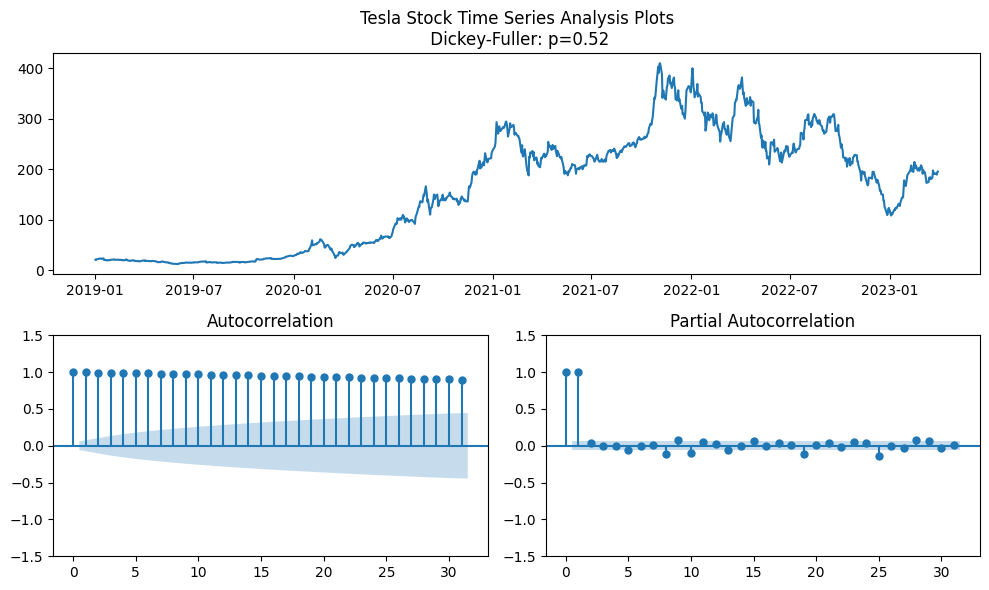

In [123]:
import matplotlib.pyplot as plt
import numpy as np

def tsplot(y, lags=None, figsize=(10, 6), tickerName = "stock", outputname = 'output/scikit-learn.png'):
    """시계열 그래프, ACF, PACF, Dickey–Fuller test 계산한다. 
    Parameters:
        y : 시계열 데이터
        lags : ACF, PACF, Dickey-Fuller 검정
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    p_value = np.round(sm.tsa.stattools.adfuller(y)[1], 2)

    fig = plt.figure(figsize=figsize)
    layout = (0.5, 0.5)

    spec = fig.add_gridspec(nrows=2, ncols=2, height_ratios=layout, width_ratios=layout)

    ### 2. setting axes
    axs = {}
    for i in range(len(layout)*len(layout)):
        if i >= 2:
            axs[i] = fig.add_subplot(spec[i//len(layout), i%len(layout)])
            # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment":"center", "color":"gray"})
        else:
            axs[i] = fig.add_subplot(spec[i//len(layout), :])
            # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment":"center", "color":"gray"})

    fig.delaxes(axs[0])

    axs[1].plot(y)
    axs[1].set_title(f'{tickerName} Stock Time Series Analysis Plots\n Dickey-Fuller: p={p_value}')

    smt.graphics.plot_acf(y, lags=lags, ax=axs[2])
    axs[2].set_ylim(-1.5, 1.5)
    axs[2].set_title('Autocorrelation')
    smt.graphics.plot_pacf(y, lags=lags, ax=axs[3])
    
    axs[3].set_ylim(-1.5, 1.5)
    axs[3].set_title('Partial Autocorrelation')

    fig.tight_layout()
    plt.savefig(outputname, dpi=200)
    plt.show()
    
tsplot(TSLA.Close, tickerName = "Tesla", outputname = 'output/scikit-learn02.png')